In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.stats import multivariate_normal as mvn
from jax import config


import vsem_jax as vsem
from vsem_inv_prob import (
    InvProb, 
    VSEMPrior, 
    VSEMLikelihood,
    VSEMTest
)

import sys
sys.path.append("./../linear_Gaussian/")
from Gaussian import Gaussian

sys.path.append("./../../helpers/")
from mcmc_uncertainty_prop import gpjaxGP, RandomKernelPCNSampler

rng = np.random.default_rng(6435)
config.update("jax_enable_x64", True)


/Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper/experiments/vsem/vsem_inv_prob.py:1073: SyntaxWarning: invalid escape sequence '\i'
  """
/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#
# Exact Inverse Problem
#

n_days = 365 * 2
par_names = ["kext", "av"]

# For exact MCMC
proposal_cov = np.diag([0.1**2, 0.04**2])

likelihood = VSEMLikelihood(rng, n_days, par_names)
prior = VSEMPrior(likelihood.par_names, rng)
inv_prob = InvProb(rng, prior, likelihood, proposal_cov=proposal_cov)

In [3]:
#
# Surrogate Inverse Problem
#

vsem_test = VSEMTest(inv_prob, n_design=20)

Optimization terminated successfully.
         Current function value: 80.893687
         Iterations: 78
         Function evaluations: 90
         Gradient evaluations: 90


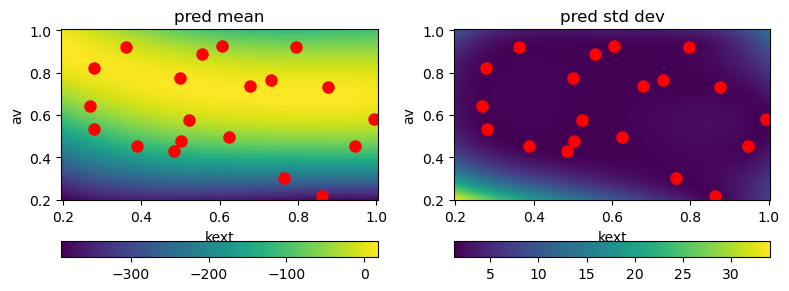

In [4]:
fig_gp, axs_gp = vsem_test.plot_gp_pred(conditional=True, pred_type='pred', markersize=8)
display(fig_gp)
plt.close()

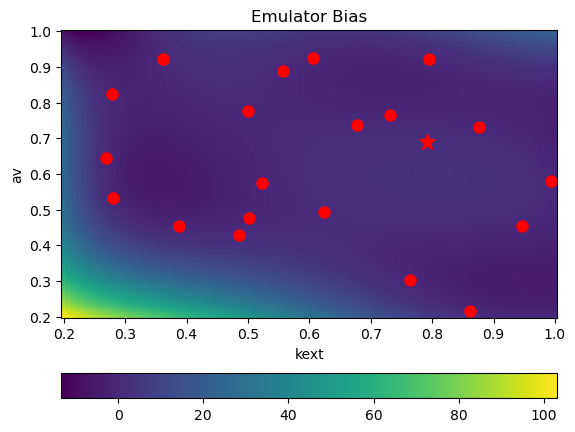

In [5]:
fig_bias, ax_bias = vsem_test.plot_gp_bias(conditional=True, pred_type='pred')

display(fig_bias)
plt.close()

In [6]:
metrics = vsem_test.compute_metrics(pred_type='pred')

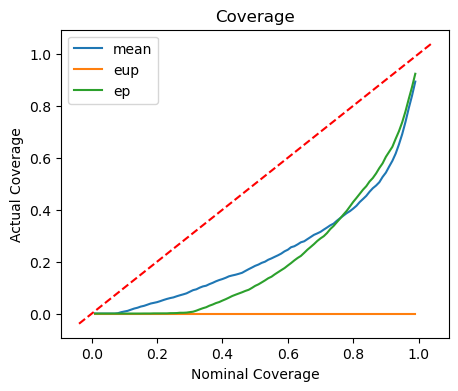

In [8]:
coverage_list = metrics['coverage']
alphas = metrics['alphas']

fig = plot_coverage(alphas, coverage_list, labels=['mean', 'eup', 'ep'])
display(fig)

In [7]:
def plot_coverage(probs, coverage_list, *, labels=None, figsize=(5,4)):
    fig, ax = plt.subplots(figsize=figsize)
    n_curves = len(coverage_list)
    if labels is None:
        labels = [f"Plot {i}" for i in range(n_curves)]

    for j in range(n_curves):
        ax.plot(probs, coverage_list[j], label=labels[j])

    ax.set_title("Coverage")
    ax.set_xlabel("Nominal Coverage")
    ax.set_ylabel("Actual Coverage")

    # Add line y = x
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    y = x
    ax.plot(x, y, color="red", linestyle="--")
    ax.legend()

    # Close figure
    plt.close(fig)
    return fig

In [ ]:
# Non-Rectified predictions
fig_log, axs_log = vsem_test.plot_posterior_comparison(shared_scale=False, log_scale=True,
                                                       pred_type='pred', nrows=2, figsize=(10,8))
fig, axs = vsem_test.plot_posterior_comparison(shared_scale=False, log_scale=False, 
                                               pred_type='pred', nrows=2, figsize=(10,8))

display(fig_log)
display(fig)
plt.close()

In [ ]:
# Rectified predictions
fig_rect_log, axs_rect_log = vsem_test.plot_posterior_comparison(shared_scale=False, log_scale=True,
                                                                 pred_type='pred_rect', nrows=2, figsize=(10,8))
fig_rect, axs_rect = vsem_test.plot_posterior_comparison(shared_scale=False, log_scale=False, 
                                                         pred_type='pred_rect', nrows=2, figsize=(10,8))

display(fig_rect_log)
display(fig_rect)
plt.close()

In [ ]:
likelihood.plot_driver()
likelihood.plot_ground_truth()

In [ ]:
inv_prob.reset_sampler()
samp, trace_plot = inv_prob.sample_posterior(n_step=20000)

display(trace_plot)

In [ ]:
plt.hist2d(samp[:,0], samp[:,1], bins=30, cmap='Blues')
plt.plot(*likelihood.par_true, "*", color="red", markersize=12)
plt.colorbar(label='Counts per bin')
plt.xlabel('u1')
plt.ylabel('u2')
plt.title('Exact posterior')
plt.show()

In [ ]:
fig_exact, ax_exact = vsem_test.plot_exact_log_post()
fig_gp_post, ax_gp_post = vsem_test.plot_gp_pred(conditional=True, latent_pred=True, figsize=(10,5))
fig_comparison, ax_comparison = vsem_test.plot_true_vs_gp_mean(conditional=True, latent_pred=True, figsize=(10,5))

fig_comparison.subplots_adjust(bottom=0.3)
display(fig_gp_post)
display(fig_comparison)

In [ ]:
log_dens_obs = lambda pred_obs: vsem_test.inv_prob.likelihood._likelihood_rv.log_p(pred_obs)
gpwrapped = gpjaxGP(vsem_test.gp_posterior, vsem_test.design, rng)
u_init = vsem_test.inv_prob.prior.sample()

rkpcn = RandomKernelPCNSampler(log_density=log_dens_obs,
                               gp=gpwrapped,
                               u_init=u_init,
                               u_prop_cov=proposal_cov,
                               pcn_cor=0.99,
                               rng=rng)

In [ ]:
rkpcn.sample(num_steps=100)

In [ ]:
n_samp = len(rkpcn.trace)
u_samp = np.empty((n_samp, prior.dim))
fu_samp = np.empty(n_samp)

for i, state in enumerate(rkpcn.trace):
    u_samp[i] = state.primary['u']
    fu_samp[i] = state.primary['fu'].squeeze()